In [1]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, time
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import openpyxl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)

## Import datasets

In [2]:
AUD = pd.read_csv('data/market liquidity/AUD.csv')
CAD = pd.read_csv('data/market liquidity/CAD.csv')
JPY = pd.read_csv('data/market liquidity/JPY.csv')

In [3]:
#in bps
AUD[['ILS','ILE','ILP']] = AUD[['ILS','ILE','ILP']]*10000
CAD[['ILS','ILE','ILP']] = CAD[['ILS','ILE','ILP']]*10000
JPY[['ILS','ILE','ILP']] = JPY[['ILS','ILE','ILP']]*1000   # for dispaly, will be changed after plotting

In [4]:
AUD_IL = AUD[['Date[G]','ILS','ILE','ILP','Return']]
AUD_IL.columns = ['Date', 'ILS_AUD/USD', 'ILE_AUD/USD', 'ILP_AUD/USD','Return_AUD/USD']
CAD_IL = CAD[['Date[G]','ILS','ILE','ILP','Return']]
CAD_IL.columns = ['Date', 'ILS_USD/CAD', 'ILE_USD/CAD', 'ILP_USD/CAD','Return_USD/CAD']
JPY_IL = JPY[['Date[G]','ILS','ILE','ILP','Return']]
JPY_IL.columns = ['Date', 'ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY','Return_USD/JPY']

In [5]:
merged_df1 = pd.merge(AUD_IL, CAD_IL, on='Date')
merged_df = pd.merge(merged_df1 , JPY_IL, on='Date')
# in bps
merged_df[['Return_AUD/USD','Return_USD/CAD','Return_USD/JPY']]=merged_df[['Return_AUD/USD','Return_USD/CAD','Return_USD/JPY']]*10000

z_scores = np.abs(stats.zscore(merged_df[['ILS_AUD/USD', 'ILE_AUD/USD', 'ILP_AUD/USD','ILS_USD/CAD', 'ILE_USD/CAD', 'ILP_USD/CAD','ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']], nan_policy='omit', axis=0))
merged_df = merged_df.loc[(z_scores <= 2).any(axis=1)]
merged_df['Date'] =  pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

#### rolling plot

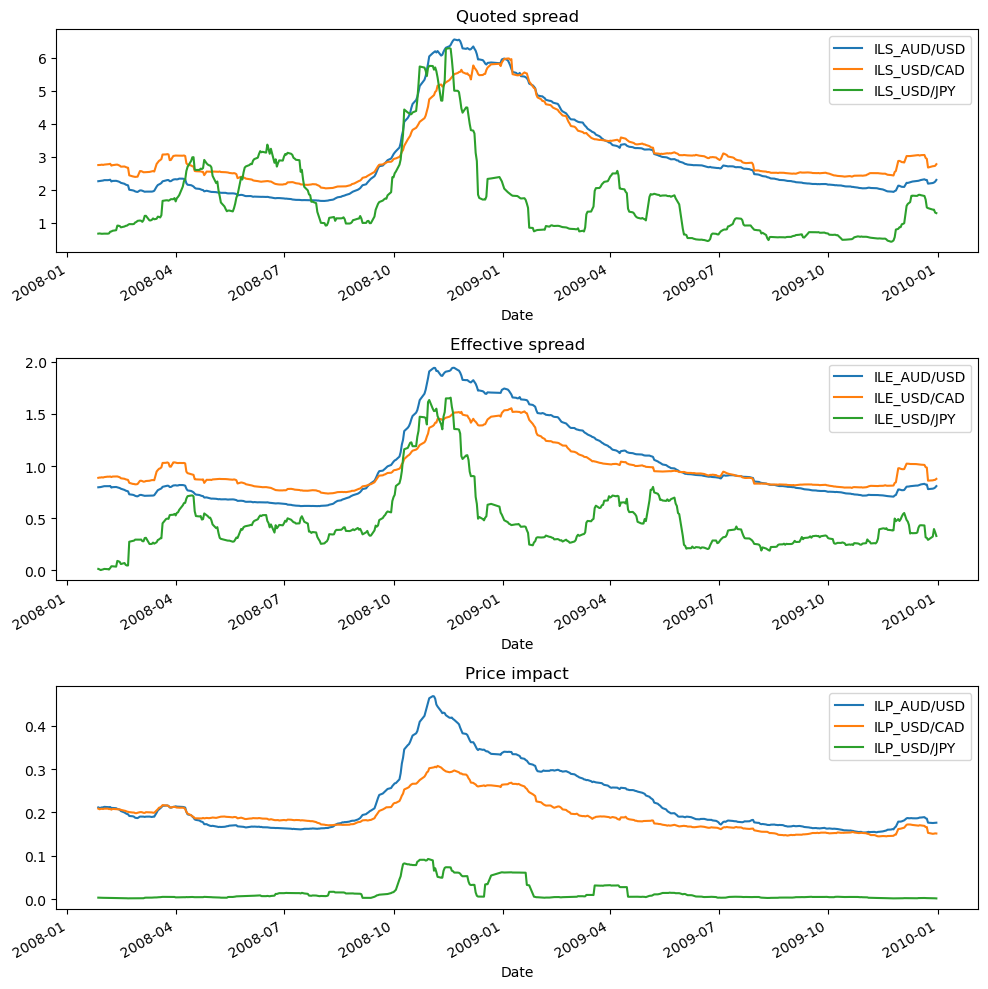

In [6]:
window_size=20

# Create a figure with three subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

# Plot the  first subplot

merged_df[['ILS_AUD/USD', 'ILS_USD/CAD', 'ILS_USD/JPY']].rolling(window_size).mean().plot(ax=axs[0], fontsize=10)
axs[0].legend(fontsize=10)
axs[0].set_title('Quoted spread')

# Plot the second subplot
merged_df[['ILE_AUD/USD', 'ILE_USD/CAD', 'ILE_USD/JPY']].rolling(window_size).mean().plot(ax=axs[1], fontsize=10)
axs[1].legend(fontsize=10)
axs[1].set_title('Effective spread')

# Plot the third subplot
merged_df[['ILP_AUD/USD', 'ILP_USD/CAD', 'ILP_USD/JPY']].rolling(window_size).mean().plot(ax=axs[2], fontsize=10)
axs[2].legend(fontsize=10)
axs[2].set_title('Price impact')

# Set a common x-axis label and tight layout
fig.tight_layout()

# Show the plot
plt.show()

#### original plot

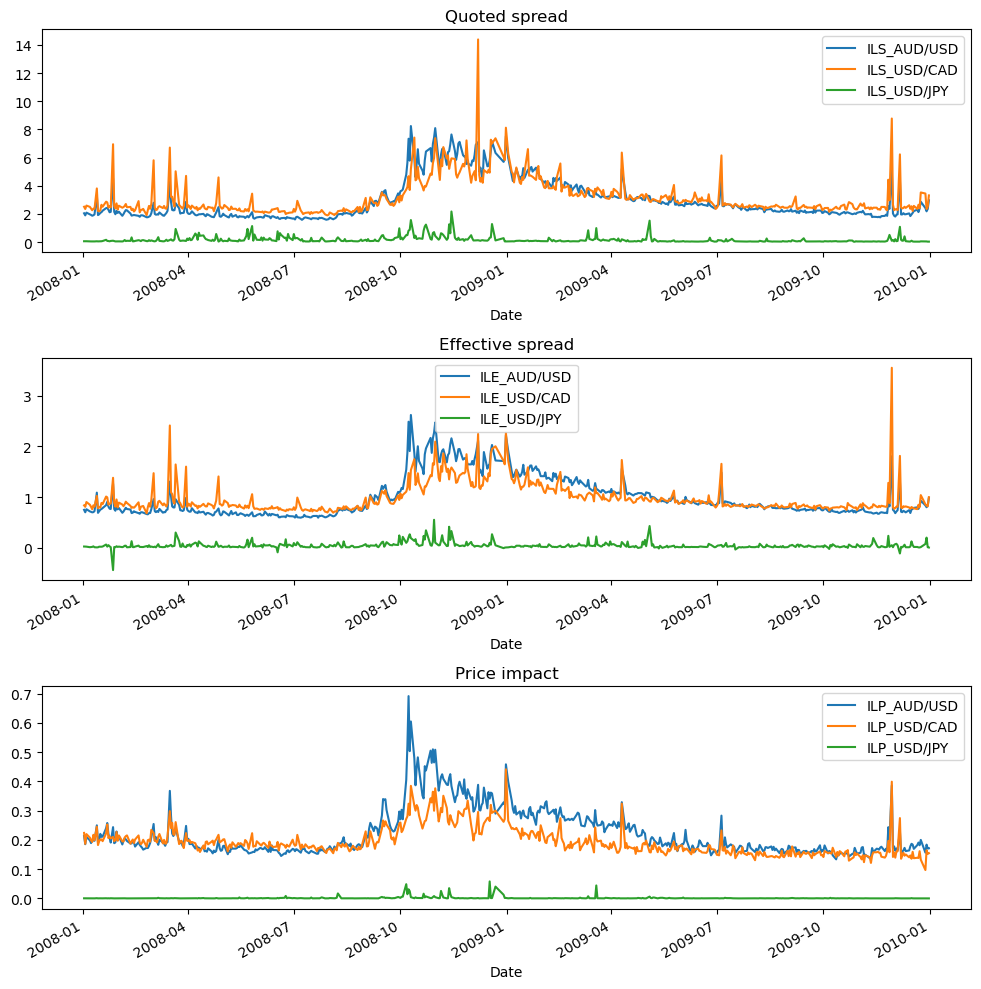

In [7]:
# Create a figure with three subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

# Plot the  first subplot
merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] = merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] /10
merged_df[['ILS_AUD/USD', 'ILS_USD/CAD', 'ILS_USD/JPY']].plot(ax=axs[0], fontsize=10)
axs[0].legend(fontsize=10)
axs[0].set_title('Quoted spread')

# Plot the second subplot
merged_df[['ILE_AUD/USD', 'ILE_USD/CAD', 'ILE_USD/JPY']].plot(ax=axs[1], fontsize=10)
axs[1].legend(fontsize=10)
axs[1].set_title('Effective spread')

# Plot the third subplot
merged_df[['ILP_AUD/USD', 'ILP_USD/CAD', 'ILP_USD/JPY']].plot(ax=axs[2], fontsize=10)
axs[2].legend(fontsize=10)
axs[2].set_title('Price impact')

# Set a common x-axis label and tight layout
fig.tight_layout()

# Show the plot
plt.show()

merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] = merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] *10

Text(0, 0.5, 'Cumulative Log-Return (in bps)')

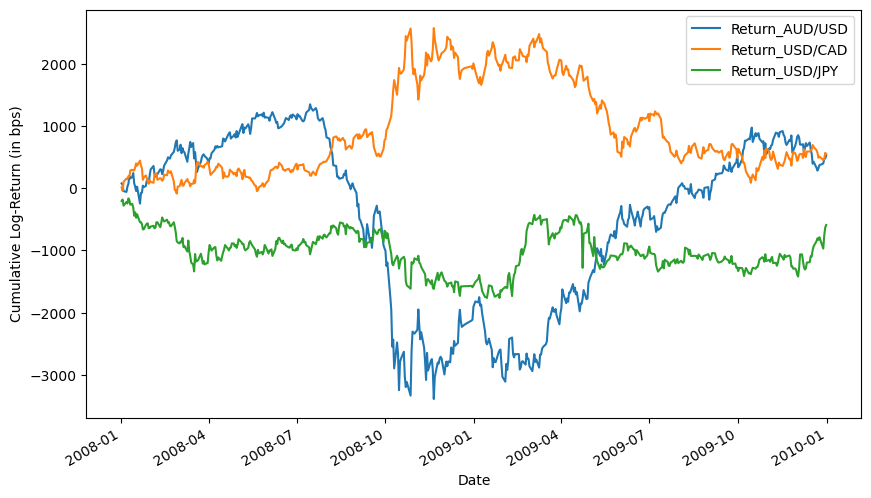

In [8]:
merged_df[['Return_AUD/USD','Return_USD/CAD','Return_USD/JPY']].cumsum().plot(figsize=(10, 6))
plt.ylabel('Cumulative Log-Return (in bps)')

## summary statistics 

In [9]:
# mutiple bcak the original data
merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] = merged_df[['ILS_USD/JPY', 'ILE_USD/JPY', 'ILP_USD/JPY']] *10

summary_statistics = merged_df.describe().T.round(3)
summary_statistics= summary_statistics.drop('count', axis=1)

In [22]:
summary_statistics

,mean,std,min,25%,50%,75%,max
ILS_AUD/USD,2.938,1.426,1.583,1.972,2.302,3.329,8.242
ILE_AUD/USD,0.983,0.394,0.594,0.710,0.806,1.116,2.618
ILP_AUD/USD,0.222,0.081,0.134,0.167,0.186,0.256,0.692
Return_AUD/USD,1.002,133.130,-594.191,-56.596,13.636,76.676,718.691
ILS_USD/CAD,3.137,1.264,1.898,2.368,2.598,3.420,14.391
ILE_USD/CAD,0.972,0.288,0.681,0.803,0.863,1.035,3.547
ILP_USD/CAD,0.193,0.047,0.097,0.161,0.182,0.207,0.441
Return_USD/CAD,1.060,90.651,-371.023,-54.947,0.000,47.543,346.271
ILS_USD/JPY,16.617,22.848,2.529,5.202,8.332,17.829,217.327
ILE_USD/JPY,4.642,6.288,-43.808,1.687,2.896,5.504,55.273


In [38]:
#print(summary_statistics.to_latex())

## PCA

In [11]:
# Create StandardScaler object
scaler = StandardScaler()
# Standardize dataframe by mean and standard deviation for each column
df_std = pd.DataFrame(scaler.fit_transform(merged_df), columns=merged_df.columns)

In [12]:
spread =df_std[['ILS_AUD/USD', 'ILS_USD/CAD', 'ILS_USD/JPY']]
espread =df_std[['ILE_AUD/USD', 'ILE_USD/CAD', 'ILE_USD/JPY']]
pi =df_std[['ILP_AUD/USD', 'ILP_USD/CAD', 'ILP_USD/JPY']]

In [13]:
pc1 =[]
goodness_of_fit=[]

In [14]:
il_list =[spread,espread,pi]
for il in il_list:
    pca = PCA(n_components=3)
    pca.fit(il)
    Spread_pca = pca.transform(il)
    # Create a new dataframe with the PCA components as columns
    df_pca = pd.DataFrame(data=Spread_pca, columns=['PC1', 'PC2', 'PC3'])
    
    pc1.append(df_pca['PC1'])
    goodness_of_fit.append(pca.explained_variance_ratio_)

In [15]:
pcs = pd.concat(pc1, axis=1)
pcs = pcs.set_index(merged_df.index)
pcs.columns = ['Quoted_spread', 'Effective_spread', 'Price_impact']

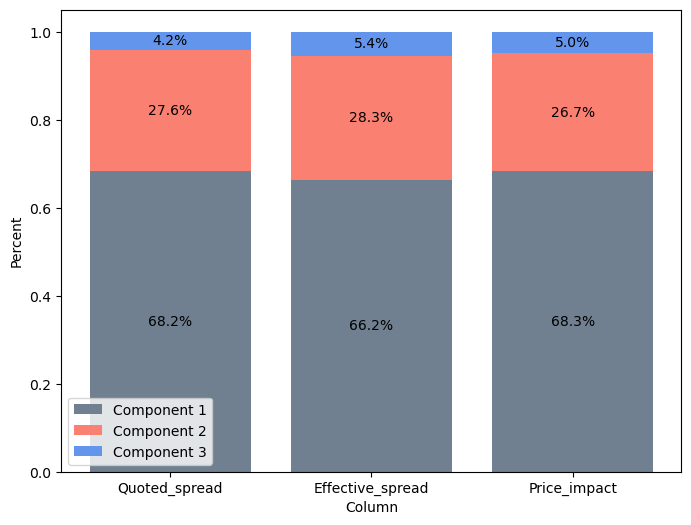

In [16]:
#data = [np.array([0.6823487 , 0.27588107, 0.04177023]),
        #np.array([0.66242895, 0.28318797, 0.05438308]),
        #np.array([0.68282416, 0.26744965, 0.04972619])]
data = np.transpose( goodness_of_fit)
colors = ['slategray', 'salmon', 'cornflowerblue']
labels = ['Component 1', 'Component 2', 'Component 3']


x = np.arange(3)


fig, ax = plt.subplots(figsize=(8, 6))
bottom = np.zeros(len(data[0]))
for i, d in enumerate(data):
    ax.bar(x, d, bottom=bottom, label=labels[i], color=colors[i])
    bottom += d
    
for i, rect in enumerate(ax.containers):
    for j, child in enumerate(rect.get_children()):
        ax.text(child.get_x() + child.get_width() / 2, 
                child.get_y() + child.get_height() / 2, 
                f'{data[i, j]*100:.1f}%', ha='center', va='center')
    
# set axis labels and legend
ax.set_xticks(x)
ax.set_xticklabels(['Quoted_spread', 'Effective_spread', 'Price_impact'])
ax.set_xlabel('Column')
ax.set_ylabel('Percent')
ax.legend()

plt.show()

## Correlation

In [17]:
noise_measure_pan  = pd.read_excel('data/market liquidity/Noise_Measure.xlsx', engine='openpyxl')

In [18]:
noise_measure_pan['Date'] = pd.to_datetime(noise_measure_pan['Date'])
noise_measure = noise_measure_pan[(noise_measure_pan['Date']<'2010-01-01')&(noise_measure_pan['Date']>'2007-12-31')]
noise_measure.set_index('Date', inplace=True)

In [19]:
correlation_df = pd.merge(merged_df,pcs, on='Date')
correlation_df['ILS_a'] = (correlation_df['ILS_AUD/USD']+correlation_df['ILS_USD/CAD'])/2
correlation_df['ILE_a'] = (correlation_df['ILE_AUD/USD']+correlation_df['ILE_USD/CAD'])/2
correlation_df['ILP_a'] = (correlation_df['ILP_AUD/USD']+correlation_df['ILP_USD/CAD'])/2
correlation_df= pd.merge(correlation_df,noise_measure,on='Date')
correlation_df = correlation_df[['Quoted_spread', 'Effective_spread', 'Price_impact','ILS_a','ILE_a','ILP_a','Noise_bp']]
correlation_df.columns = ['ILS_pca', 'ILE_pca','ILP_pca', 'ILS_a','ILE_a','ILP_a','Noise_bp']

In [20]:
correlation_df.to_csv('data/market liquidity/Market Illiquidity.csv')

In [21]:
# Compute correlation matrix and p-values
corr, pvalues = correlation_df.corr(method='pearson').round(3), correlation_df.corr(method=lambda x, y: pearsonr(x, y)[1]).round(3)


# Get lower triangle of correlation matrix including diagonal
corr_lower = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

# Add significance levels to correlation matrix
corr_significance = corr_lower.applymap(lambda x: '{:.2f}***'.format(x) if (x > 0.01) else '')


corr_significance 

,ILS_pca,ILE_pca,ILP_pca,ILS_a,ILE_a,ILP_a,Noise_bp
ILS_pca,1.00***,,,,,,
ILE_pca,0.98***,1.00***,,,,,
ILP_pca,0.86***,0.88***,1.00***,,,,
ILS_a,0.96***,0.96***,0.84***,1.00***,,,
ILE_a,0.96***,0.97***,0.87***,0.99***,1.00***,,
ILP_a,0.89***,0.90***,0.96***,0.88***,0.91***,1.00***,
Noise_bp,0.84***,0.83***,0.73***,0.88***,0.87***,0.78***,1.00***


## Table 3:  Individual liquidity and market-wide liquidity

In [30]:
spread = spread.set_index(merged_df.index)
espread =espread.set_index(merged_df.index)
pi = pi.set_index(merged_df.index)
merged_std = pd.merge(spread,espread, left_index=True, right_index=True)
merged_std = pd.merge(merged_std,pi, left_index=True, right_index=True)

In [31]:
merged_std.to_csv('data/market liquidity/Market Illiquidity(individual).csv')

In [32]:
# get the market-wide liquidity excluding currency and then reg
pc1s = []
il_list =[spread,espread,pi]
for il in il_list:
    names = il.columns
    for j in names:
        temp = il.drop(j, axis=1)
        pca = PCA(n_components=2)
        pca.fit(temp)
        Spread_pca = pca.transform(temp)
        df_pca = pd.DataFrame(data=Spread_pca, columns=['PC1', 'PC2'])
        pc1s.append(df_pca['PC1'])
pcs = pd.concat(pc1s, axis=1)
pcs = pcs.set_index(merged_df.index)
pcs.columns = ['PCILSAUD','PCILSCAD','PCILSJPY','PCILEAUD','PCILECAD','PCILEJPY','PCILPAUD','PCILPCAD','PCILPJPY']
merged_std.columns = ['ILSAUD','ILSCAD','ILSJPY','ILEAUD','ILECAD','ILEJPY','ILPAUD','ILPCAD','ILPJPY']
market_individual= pd.merge(merged_std, pcs,left_index=True, right_index=True)

In [33]:
model1 = smf.ols('ILSAUD~PCILSAUD', data=market_individual)
result1 = model1.fit()

model2 = smf.ols('ILEAUD~PCILEAUD', data=market_individual)
result2 = model2.fit()

model3 = smf.ols('ILPAUD~PCILPAUD', data=market_individual)
result3 = model3.fit()

model4 = smf.ols('ILSCAD~PCILSCAD', data=market_individual)
result4 = model4.fit()

model5 = smf.ols('ILECAD~PCILECAD', data=market_individual)
result5 = model5.fit()

model6 = smf.ols('ILPCAD~PCILPCAD', data=market_individual)
result6 = model6.fit()

model7 = smf.ols('ILSJPY~PCILSJPY', data=market_individual)
result7 = model7.fit()

model8 = smf.ols('ILEJPY~PCILEJPY', data=market_individual)
result8 = model8.fit()

model9 = smf.ols('ILPJPY~PCILPJPY', data=market_individual)
result9 = model9.fit()


results =  summary_col([result1,result2,result3,result4,result5,result6,result7,result8,result9],
                       stars=True,
                       float_format='%0.2f',
                       model_names=['ILSAUD','ILEAUD','ILPAUD','ILSCAD','ILECAD','ILPCAD','ILSJPY','ILEJPY','ILPJPY'],
                       regressor_order=['PCILSAUD','PCILEAUD','PCILPAUD','PCILSCAD','PCILECAD','PCILPCAD','PCILSJPY','PCILEJPY','PCILPJPY'],  # chcnage the column name 
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                       drop_omitted=True
                       )
print(results)



                ILSAUD  ILEAUD  ILPAUD  ILSCAD  ILECAD  ILPCAD  ILSJPY  ILEJPY  ILPJPY
--------------------------------------------------------------------------------------
PCILSAUD       0.69***                                                                
               (0.02)                                                                 
PCILEAUD               0.67***                                                        
                       (0.03)                                                         
PCILPAUD                       0.66***                                                
                               (0.03)                                                 
PCILSCAD                               0.58***                                        
                                       (0.03)                                         
PCILECAD                                       0.56***                                
                                          

## Table 4: FX commonality in distressed market

In [35]:
VIX = pd.read_csv('data/market liquidity/funding liquidity/VIXCLS.csv')
TED = pd.read_csv('data/market liquidity/funding liquidity/TEDRATE.csv')
VIX_TED = pd.merge(VIX,TED,on='DATE')
VIX_TED.columns = ['Date','VIX','TED']
VIX_TED['Date'] = pd.to_datetime(VIX_TED['Date'])

In [36]:
# table 4
VIX_TED_IL_individual = pd.merge(market_individual,VIX_TED,on='Date')
VIX_TED_IL_individual.set_index('Date',inplace =True)
VIX_TED_IL_individual = VIX_TED_IL_individual.apply(pd.to_numeric, errors='coerce')
VIX_TED_IL_individual = VIX_TED_IL_individual.dropna()

In [37]:
model1 = smf.ols('ILSAUD~PCILSAUD+VIX', data=VIX_TED_IL_individual)
result1 = model1.fit()

model2 = smf.ols('ILEAUD~PCILEAUD+VIX', data=VIX_TED_IL_individual)
result2 = model2.fit()

model3 = smf.ols('ILPAUD~PCILPAUD+VIX', data=VIX_TED_IL_individual)
result3 = model3.fit()

model4 = smf.ols('ILSCAD~PCILSCAD+VIX', data=VIX_TED_IL_individual)
result4 = model4.fit()

model5 = smf.ols('ILECAD~PCILECAD+VIX', data=VIX_TED_IL_individual)
result5 = model5.fit()

model6 = smf.ols('ILPCAD~PCILPCAD+VIX', data=VIX_TED_IL_individual)
result6 = model6.fit()

model7 = smf.ols('ILSJPY~PCILSJPY+VIX', data=VIX_TED_IL_individual)
result7 = model7.fit()

model8 = smf.ols('ILEJPY~PCILEJPY+VIX', data=VIX_TED_IL_individual)
result8 = model8.fit()

model9 = smf.ols('ILPJPY~PCILPJPY+VIX', data=VIX_TED_IL_individual)
result9 = model9.fit()


results =  summary_col([result1,result2,result3,result4,result5,result6,result7,result8,result9],
                       stars=True,
                       float_format='%0.2f',
                       model_names=['ILSAUD','ILEAUD','ILPAUD','ILSCAD','ILECAD','ILPCAD','ILSJPY','ILEJPY','ILPJPY'],
                       regressor_order=['PCILSAUD','PCILEAUD','PCILPAUD','PCILSCAD','PCILECAD','PCILPCAD','PCILSJPY','PCILEJPY','PCILPJPY','VIX'],  # chcnage the column name 
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                       drop_omitted=True
                       )
print(results)


                ILSAUD  ILEAUD  ILPAUD  ILSCAD  ILECAD  ILPCAD ILSJPY ILEJPY  ILPJPY
------------------------------------------------------------------------------------
PCILSAUD       0.30***                                                              
               (0.02)                                                               
PCILEAUD               0.30***                                                      
                       (0.02)                                                       
PCILPAUD                       0.30***                                              
                               (0.02)                                               
PCILSCAD                               0.21***                                      
                                       (0.03)                                       
PCILECAD                                       0.27***                              
                                               (0.03)           

In [641]:
model1 = smf.ols('ILSAUD~PCILSAUD+TED', data=VIX_TED_IL_individual)
result1 = model1.fit()

model2 = smf.ols('ILEAUD~PCILEAUD+TED', data=VIX_TED_IL_individual)
result2 = model2.fit()

model3 = smf.ols('ILPAUD~PCILPAUD+TED', data=VIX_TED_IL_individual)
result3 = model3.fit()

model4 = smf.ols('ILSCAD~PCILSCAD+TED', data=VIX_TED_IL_individual)
result4 = model4.fit()

model5 = smf.ols('ILECAD~PCILECAD+TED', data=VIX_TED_IL_individual)
result5 = model5.fit()

model6 = smf.ols('ILPCAD~PCILPCAD+TED', data=VIX_TED_IL_individual)
result6 = model6.fit()

model7 = smf.ols('ILSJPY~PCILSJPY+TED', data=VIX_TED_IL_individual)
result7 = model7.fit()

model8 = smf.ols('ILEJPY~PCILEJPY+TED', data=VIX_TED_IL_individual)
result8 = model8.fit()

model9 = smf.ols('ILPJPY~PCILPJPY+TED', data=VIX_TED_IL_individual)
result9 = model9.fit()


results =  summary_col([result1,result2,result3,result4,result5,result6,result7,result8,result9],
                       stars=True,
                       float_format='%0.2f',
                       model_names=['ILSAUD','ILEAUD','ILPAUD','ILSCAD','ILECAD','ILPCAD','ILSJPY','ILEJPY','ILPJPY'],
                       regressor_order=['PCILSAUD','PCILEAUD','PCILPAUD','PCILSCAD','PCILECAD','PCILPCAD','PCILSJPY','PCILEJPY','PCILPJPY','TED'],  # chcnage the column name 
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                       drop_omitted=True
                       )
print(results)


                ILSAUD  ILEAUD  ILPAUD  ILSCAD  ILECAD  ILPCAD  ILSJPY  ILEJPY  ILPJPY
--------------------------------------------------------------------------------------
PCILSAUD       0.70***                                                                
               (0.03)                                                                 
PCILEAUD               0.71***                                                        
                       (0.03)                                                         
PCILPAUD                       0.40***                                                
                               (0.03)                                                 
PCILSCAD                               0.56***                                        
                                       (0.03)                                         
PCILECAD                                       0.53***                                
                                          

In [39]:
#print(results.as_latex())

## Returns

In [40]:
returns_df = merged_df[['Return_AUD/USD','Return_USD/CAD','Return_USD/JPY']]
returns_df

,Return_AUD/USD,Return_USD/CAD,Return_USD/JPY
Date,,,
2008-01-02,80.084488,14.590830,-202.512187
2008-01-03,-22.088192,-54.946578,23.311632
2008-01-04,-102.009718,145.548366,-99.092471
2008-01-07,-12.610342,53.330802,59.677004
2008-01-08,86.803126,-7.957032,-24.741147
...,...,...,...
2009-12-24,49.318430,17.624507,42.061625
2009-12-28,27.665659,-52.114579,-183.410533
2009-12-29,74.708956,14.371260,213.312101


In [41]:
return_liquidity = pd.merge(returns_df,correlation_df,on='Date')

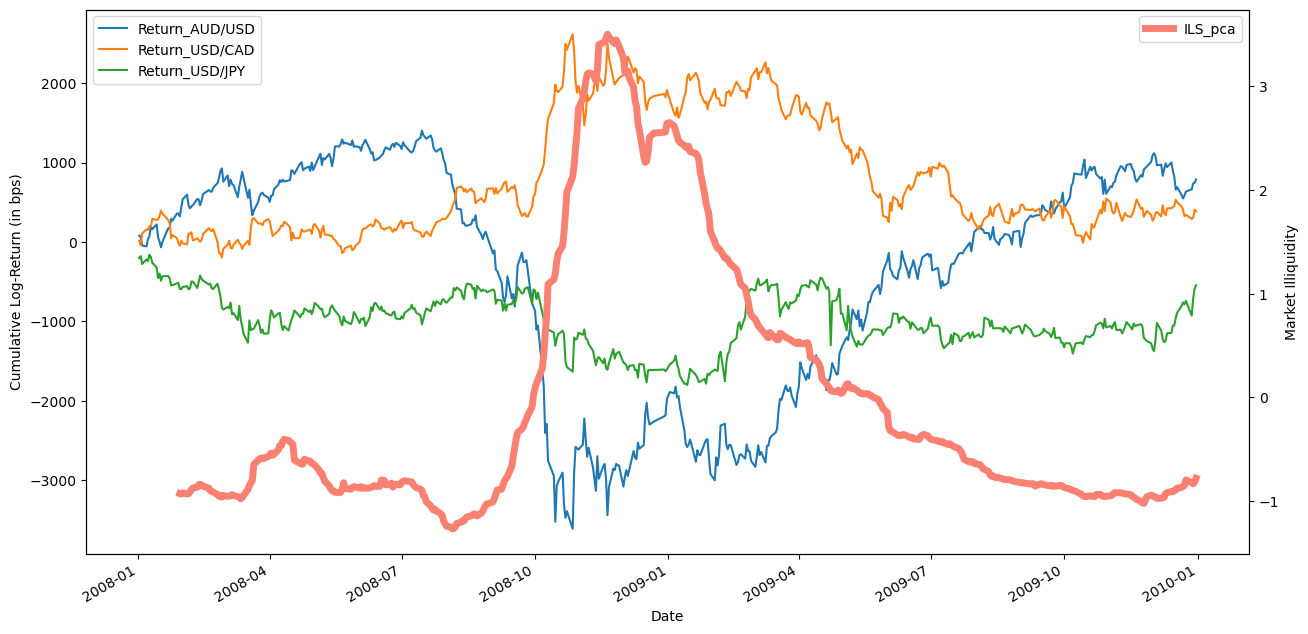

In [42]:
# plot time series with two y-axes
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

return_liquidity[['Return_AUD/USD','Return_USD/CAD','Return_USD/JPY']
                ].cumsum().plot(ax=ax1, label=['AUD/USD','USD/CAD','USD/JPY'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Log-Return (in bps)')
ax1.tick_params('y')
ax1.legend(loc='upper left')


# plot first column with left y-axis


# plot second column with right y-axis
return_liquidity['ILS_pca'].rolling(window_size).mean().plot(ax=ax2,label='ILS_pca',color='salmon',linewidth=5)
ax2.set_ylabel('Market Illiquidity')
ax2.tick_params('y')
ax2.legend(loc='upper right')
plt.show()

In [43]:
AUD_test = merged_df[['ILS_USD/JPY','ILE_USD/JPY','ILP_USD/JPY','Return_USD/JPY']]
AUD_test.columns = ['ILS','ILE','ILP','Return']

In [44]:
model_AUD_test= smf.ols('Return~ Return.shift()+ILP.shift()', data=AUD_test)
resultl_model_AUD_test =model_AUD_test.fit()
resultl_model_AUD_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.659
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           0.000527
Time:                        15:47:56   Log-Likelihood:                -3099.4
No. Observations:                 524   AIC:                             6205.
Df Residuals:                     521   BIC:                             6218.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7401      4.083     -0.181      0.856      -8.762       7.281
Return.shift()    -0.1694      0.044     -3.883      0.000      -0.255      -0.084
ILP.shift()       -1.3888      7.743     -0.179      0.858     -16.600      13.823
==============================================================================
Omnibus:                      124.506   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1598.614
Skew:                          -0.632   Prob(JB):                         0.00
Kurtosis:                      11.463   Cond. No.                         183.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Funding liquidity

In [45]:
VIX_TED_IL = pd.merge(correlation_df,VIX_TED,on='Date')
VIX_TED_IL.set_index('Date',inplace =True)
VIX_TED_IL = VIX_TED_IL.apply(pd.to_numeric, errors='coerce')
VIX_TED_IL['VIX'] =VIX_TED_IL['VIX'] /10

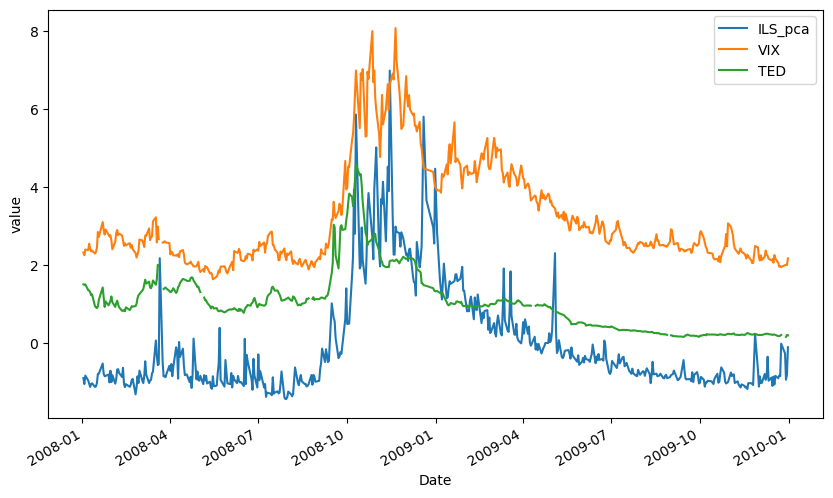

In [46]:
VIX_TED_IL[['ILS_pca','VIX','TED']].plot(figsize=(10, 6))
#plt.ylabel('Funding liquidity and market liquidity')
plt.ylabel('value')
VIX_TED_IL['VIX'] =VIX_TED_IL['VIX']*10

## Table 5: Funding liquidity and market liquidity

In [47]:
VIX_TED_IL =VIX_TED_IL .dropna()
model1 = smf.ols('ILS_pca ~ VIX.shift()', data=VIX_TED_IL)
result1 = model1.fit()

model2 = smf.ols('ILS_pca ~ TED.shift()', data=VIX_TED_IL)
result2 = model2.fit()

model3 = smf.ols('ILS_pca ~ VIX.shift()+TED.shift()', data=VIX_TED_IL)
result3 = model3.fit()

model4 = smf.ols('ILS_pca ~ ILS_pca.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result4 = model4.fit()

before_crisis = VIX_TED_IL[VIX_TED_IL.index<'2008-09-20']
model5 = smf.ols('ILS_pca ~ VIX.shift()', data=before_crisis)
result5 = model5.fit()
model6 = smf.ols('ILS_pca ~ TED.shift()', data=before_crisis)
result6 = model6.fit()
model7 = smf.ols('ILS_pca ~ VIX.shift()+TED.shift()', data=before_crisis)
result7 = model7.fit()
model8 = smf.ols('ILS_pca ~ ILS_pca.shift()+VIX.shift()+TED.shift()', data=before_crisis)
result8 = model8.fit()

In [48]:
results= summary_col([result1,result2,result3,result4,result5,result6,result7,result8],
                       stars=True,
                       float_format='%0.2f',
                       model_names=['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)'],
                       regressor_order=result4.params.index.tolist(),
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                       drop_omitted=True
                       )

In [49]:
print(results)


                  (1)      (2)      (3)      (4)      (5)      (6)      (7)      (8)   
---------------------------------------------------------------------------------------
Intercept       -2.94*** -1.17*** -2.91*** -0.96*** -1.61*** -1.41*** -1.70*** -0.70***
                (0.08)   (0.08)   (0.08)   (0.12)   (0.20)   (0.11)   (0.19)   (0.20)  
ILS_pca.shift()                            0.66***                             0.56*** 
                                           (0.04)                              (0.07)  
VIX.shift()     0.09***           0.08***  0.03***  0.03***           0.02*    0.01    
                (0.00)            (0.00)   (0.00)   (0.01)            (0.01)   (0.01)  
TED.shift()              1.04***  0.20***  0.08**            0.49***  0.41***  0.15*   
                         (0.06)   (0.05)   (0.04)            (0.09)   (0.09)   (0.09)  
R-squared       0.75     0.36     0.76     0.86     0.08     0.16     0.17     0.40    
R-squared Adj.  0.75     0.36  

In [615]:
#print(results.as_latex())

## Table B1: Funding liquidity and market liquidity: alternative proxies

In [50]:
model_measure1 = smf.ols('ILS_pca ~ ILS_pca.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure1= model_measure1 .fit()

model_measure2 = smf.ols('ILE_pca ~ ILE_pca.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure2= model_measure2 .fit()

model_measure3 = smf.ols('ILP_pca ~ ILP_pca.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure3= model_measure3 .fit()

model_measure4 = smf.ols('ILS_a ~ ILS_a.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure4= model_measure4 .fit()

model_measure5 = smf.ols('ILE_a ~ ILE_a.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure5= model_measure5 .fit()

model_measure6 = smf.ols('ILP_a ~ ILP_a.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure6= model_measure6 .fit()

model_measure7 = smf.ols('Noise_bp ~ Noise_bp.shift()+VIX.shift()+TED.shift()', data=VIX_TED_IL)
result_measure7= model_measure7 .fit()

results_measure= summary_col([result_measure1,result_measure2,result_measure3,result_measure4,result_measure5,result_measure6,
                              result_measure7],
                       stars=True,
                       float_format='%0.2f',
                       model_names=['ILS_pca', 'ILE_pca','ILP_pca', 'ILS_a','ILE_a','ILP_a','Noise_bp'],
                       regressor_order=['VIX.shift()','TED.shift()','ILS_pca.shift()','ILE_pca.shift()',
                                       'ILP_pca.shift()','ILS_a.shift()','ILE_a.shift()','ILP_a.shift()','Noise_bp.shift()'],
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))},
                       drop_omitted=True
                       )

In [51]:
print(results_measure)  


                 ILS_pca ILE_pca ILP_pca  ILS_a   ILE_a   ILP_a  Noise_bp
-------------------------------------------------------------------------
VIX.shift()      0.03*** 0.03*** 0.02*** 0.02*** 0.00*** 0.00*** 0.01**  
                 (0.00)  (0.00)  (0.00)  (0.00)  (0.00)  (0.00)  (0.00)  
TED.shift()      0.08**  0.08**  0.38*** 0.02    0.01    0.01*** 0.10*** 
                 (0.04)  (0.04)  (0.05)  (0.02)  (0.01)  (0.00)  (0.03)  
ILS_pca.shift()  0.66***                                                 
                 (0.04)                                                  
ILE_pca.shift()          0.66***                                         
                         (0.03)                                          
ILP_pca.shift()                  0.58***                                 
                                 (0.04)                                  
ILS_a.shift()                            0.79***                         
                                     

In [616]:
#print(results_measure.as_latex())